<a href="https://colab.research.google.com/github/jjschueder/7331DataMiningNotebooks/blob/master/lab3/Lab3_Daniel_Jeff_Armando_Joe_small_spectral.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Data Mining 7331 - Spring 2020**

DUE APRIL 12th (sunday)



* jw - update data understanding 1, 2.  
  * Update doc contents.  Start on pair wise clustering for liquor type and sales, store type and sales (covariance table - 90% related) cluster based on data understanding (to_keep section).  From lab 2, do the most imporant ones (bottle_volume_ml, bottle_cost, cost_per_liter) and then do all 10 using knn.  Use lab 1 visualization for scatterplots for liquior types.  Then look at clusters. s&s pair plot, lab 1 - go against normalize data

  * sns.pairplot(dfenc, height=3, hue= 'liquor_category', vars = ['state_bottle_retail', 'sale_dollars', 'bottles_sold', 'volume_sold_liters'])

  * plot the correlation matrix using seaborn

  * https://towardsdatascience.com/visualizing-data-with-pair-plots-in-python-f228cf529166
import seaborn as sns
cmap = sns.diverging_palette(220, 10, as_cmap=True) # one of the many color mappings

  * drop the counter attribute as that was used above when dealing with missing values
del df['counter']

  * show the heatmap
sns.set(style="darkgrid") # one of the many styles to plot using
f, ax = plt.subplots(figsize=(18, 9))
chart=sns.heatmap(df.corr(), cmap=cmap, annot=True)
chart.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
f.tight_layout()

* Daniel
  * send professtor about spectral - min num of datapoints needed
  * look into using dbscan - modifying params for better results

* Armando
  * looking into evaluating clusters - notebook 10
  * Business Understanding

* Joe
  * Agglomorative
  * Graph-based clustering






## Lab 3 -  Clustering, Association Rules, or Recommenders 

#### Daniel Clark, Joe Schueder, Jeff Washburn, Armando Vela

Final Team Project
CRISP-DM Capstone: Association Rule Mining, Clustering, or Collaborative Filtering  
In the final assignment for this course, you will be using one of three different analysis methods:  
• Option A: Use clustering on an unlabeled dataset to provide insight or features  
• Option B: Use transaction data for mining associations rules  
• Option C: Use collaborative filtering to build a custom recommendation system
Your choice of dataset will largely determine the task that you are trying to achieve, though the
dataset does not need to change from your previous tasks.  
• For example, you might choose to use clustering on your data as a preprocessing step that  
extracts different features. Then you can use those features to build a classifier and analyze
its performance in terms of accuracy (precision, recall) and speed.  
• Alternatively, you might choose a completely different dataset and perform rule mining or
build a recommendation system.
Dataset Selection and Toolkits
As before, you need to choose a dataset that is not small. It might be massive in terms of the
number of attributes (or transactions), classes (or items, users, etc.) or whatever is appropriate
for the task you are performing. Note that scikit-learn can be used for clustering analysis, but not
for Association Rule Mining (you should use R) or collaborative filtering (you should use
graphlabcreate from Dato). Both can be run using Jupyter notebooks as shown in lecture.  
• One example of a recommendation dataset is the movie lens rating data:
http://grouplens.org/ datasets/movielens/  
• Some examples of association rule mining datasets: http://fimi.ua.ac.be/data/
Write a report covering in detail all the steps of the project. The results need to be reproducible
using only this report. Describe all assumptions you make and include all code you use in the
Jupyter notebook or as supplemental functions. Follow the CRISP-DM framework in your
analysis (you are performing all of the CRISP-DM outline).  
This report is worth 20% of the final grade. 

## Business Understanding 1 (10 points)



Describe the purpose of the data set you selected (i.e., why was this data
collected in the first place?). How will you measure the effectiveness of a good algorithm?
- look at class notebook on evaluating clusters (notebook 10 - cluster validity)

Why does your chosen validation method make sense for this specific dataset and the stakeholders needs?

## Data Understanding 1 (10 points)


Describe the meaning and type of data (scale, values, etc.) for each attribute in
the data file. Verify data quality: Are there missing values? Duplicate data? Outliers? Are
those mistakes? How do you deal with these problems?

In [1]:
import pandas as pd

url_dataset = 'https://raw.githubusercontent.com/jjschueder/7331DataMiningNotebooks/master/Live%20Assignments/df1hotmerge2.csv'
data = pd.read_csv(url_dataset, nrows = 40000)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 68 columns):
Unnamed: 0                  40000 non-null int64
pack                        40000 non-null int64
bottle_volume_ml            40000 non-null int64
state_bottle_cost           40000 non-null float64
state_bottle_retail         40000 non-null float64
bottles_sold                40000 non-null int64
sale_dollars                40000 non-null float64
volume_sold_liters          40000 non-null float64
volume_sold_gallons         40000 non-null float64
counter                     40000 non-null int64
liquor_category             40000 non-null object
store_parent                40000 non-null object
month                       40000 non-null object
year                        40000 non-null int64
monthyear                   40000 non-null object
liquor_category_AMARETTO    40000 non-null int64
liquor_category_BRANDY      40000 non-null int64
liquor_category_GIN         40000 non-null i

In [2]:
# Import all necessary libraries we will be using in our dataset

import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import math
import re
import sklearn
import statistics
import random

from sklearn.feature_selection import SelectKBest, chi2, SelectPercentile, RFE, SelectFromModel

from sklearn.preprocessing import StandardScaler, Binarizer

from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import SVC, LinearSVC

from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, auc, roc_curve
from IPython.display import display, HTML

from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, TimeSeriesSplit, StratifiedShuffleSplit

from sklearn.naive_bayes import MultinomialNB

from sklearn.ensemble import GradientBoostingClassifier,GradientBoostingRegressor,AdaBoostClassifier,RandomForestClassifier, BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

%matplotlib inline

matplotlib.style.use('ggplot')

import warnings
warnings.filterwarnings('ignore')
print(data.shape)
data.head()

(40000, 68)


,Unnamed: 0,pack,bottle_volume_ml,state_bottle_cost,state_bottle_retail,bottles_sold,sale_dollars,volume_sold_liters,volume_sold_gallons,counter,liquor_category,store_parent,month,year,monthyear,liquor_category_AMARETTO,liquor_category_BRANDY,liquor_category_GIN,liquor_category_LIQUEUR,liquor_category_Other,liquor_category_RUM,liquor_category_SCHNAPPS,liquor_category_TEQUILA,liquor_category_VODKA,liquor_category_WHISKY,store_parent_CVS,store_parent_Caseys,store_parent_Hy-Vee,store_parent_Kum&Go,store_parent_Other,store_parent_QuikTrip,store_parent_SamsClub,store_parent_SmokingJoes,store_parent_Target,store_parent_Wal-Mart,store_parent_Walgreens,month_Apr,month_Aug,month_Dec,month_Feb,month_Jan,month_Jul,month_Jun,month_Mar,month_May,month_Nov,month_Oct,month_Sep,year_2019,monthyear_Apr-2019,monthyear_Aug-2019,monthyear_Dec-2019,monthyear_Feb-2019,monthyear_Jan-2019,monthyear_Jul-2019,monthyear_Jun-2019,monthyear_Mar-2019,monthyear_May-2019,monthyear_Nov-2019,monthyear_Oct-2019,monthyear_Sep-2019,sale_dollars_trans,cost_per_liter,cost_per_liter_trans,state_bottle_cost_trans,bottles_sold_trans,volume_sold_liters_trans,grossmargin
0,0,20,375,3.85,5.78,20,115.60,7.50,1.98,1,Other,Other,Nov,2019,Nov-19,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,4.750136,15.413333,2.735233,1.348073,2.995732,2.014903,0.333910
1,1,8,50,8.75,13.13,1,13.13,0.05,0.01,1,Other,Other,Nov,2019,Nov-19,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,2.574900,262.600000,5.570632,2.169054,0.000000,-2.995732,0.333587
2,2,12,1000,16.50,24.75,6,148.50,6.00,1.58,1,GIN,Hy-Vee,May,2019,May-19,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,5.000585,24.750000,3.208825,2.803360,1.791759,1.791759,0.333333
3,3,6,750,21.17,31.76,24,762.24,18.00,4.75,1,WHISKY,Hy-Vee,Nov,2019,Nov-19,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,6.636261,42.346667,3.745890,3.052585,3.178054,2.890372,0.333438
4,4,6,1750,9.31,13.97,12,167.64,21.00,5.54,1,Other,Hy-Vee,Nov,2019,Nov-19,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,5.121819,7.982857,2.077296,2.231089,2.484907,3.044522,0.333572


In [3]:
# Since we are predicting our liquor category type (opening to the entire list of categories and not just one), we can assign them a numerical value.

print (data['liquor_category'].unique())

"""df = pd.DataFrame({'col_1':[133,255,36,477,55,63]})
d = {'1':'M', '2': 'C', '3':'a', '4':'f', '5':'r', '6':'s'}
def ifef(col):
    col = str(col)
    return d[col[0]]

df['id_label'] = df['col_1'].apply(ifef)
print(df)"""

d = {'O':'1', 'G': '2', 'W':'3', 'T':'4', 'L':'5', 'V':'6', 'R':'7', 'S': '8', 'A':'9', 'B':'10'}

#data['id_label'] = data['liquor_category'].apply(ifef)

data['id_label'] = data['liquor_category'].astype(str).str[0].map(d)

print(data.head())

['Other' 'GIN' 'WHISKY' 'TEQUILA' 'LIQUEUR' 'VODKA' 'RUM' 'SCHNAPPS'
 'AMARETTO' 'BRANDY']
   Unnamed: 0  pack  ...  grossmargin  id_label
0           0    20  ...     0.333910         1
1           1     8  ...     0.333587         1
2           2    12  ...     0.333333         2
3           3     6  ...     0.333438         3
4           4     6  ...     0.333572         1

[5 rows x 69 columns]


In [0]:
# Create new variables using aggredate data on profit, total cost and revenue

#do some calculations for cost and profit
data['profit'] = data['state_bottle_retail']*data['bottles_sold'] - data['state_bottle_cost']* data['bottles_sold']
data['profit_trans']= np.log(data['profit'])

data['totalcost'] = data['state_bottle_cost']* data['bottles_sold']
data['totalcost_trans']= np.log(data['totalcost'])

data['revenue'] = data['state_bottle_retail']*data['bottles_sold']
data['revenue_trans']= np.log(data['revenue'])

data['bottle_volume_ml_trans']= np.log(data['bottle_volume_ml'])

data['pack_trans']= np.log(data['pack'])

## Data Understanding 2 (10 points)

Visualize any important attributes appropriately

Visualize the any important attributes appropriately. Important: Provide an interpretation for any charts or graphs

(40000, 11)


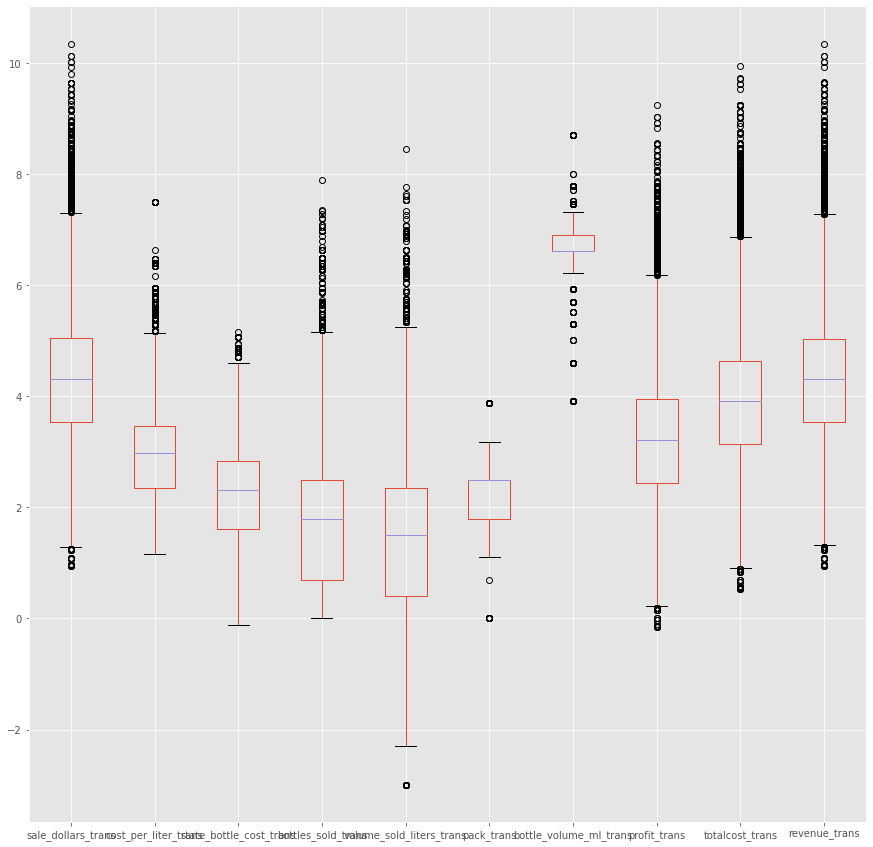

In [5]:
# Since we transformed a number of continuous variables, we can drop them so that we are working directly on our normalized data


# Remove unwanted columns, which include all the specific liquor categories, 
# except for liquor_category_WHISKY since that is what we want to classify on, along
# with all the store_ attributes
"""
cat_vars=['counter', 'liquor_category', 'store_parent',
 'month', 'year', 'monthyear', 'liquor_category_AMARETTO', 'liquor_category_BRANDY', 'liquor_category_GIN', 
 'liquor_category_LIQUEUR', 'liquor_category_Other', 'liquor_category_RUM', 'liquor_category_SCHNAPPS', 
 'liquor_category_TEQUILA', 'liquor_category_VODKA', 'month_Apr', 'month_Aug', 'month_Dec', 'month_Feb',
 'month_Jan', 'month_Jul', 'month_Jun', 'month_Mar', 'month_May', 'month_Nov', 'month_Oct', 'month_Sep', 
 'store_parent_CVS', 'store_parent_Caseys', 'store_parent_Hy-Vee', 'store_parent_Kum&Go', 
 'store_parent_Other', 'store_parent_QuikTrip', 'store_parent_SamsClub', 'store_parent_SmokingJoes', 
 'store_parent_Target', 'store_parent_Wal-Mart', 'store_parent_Walgreens']
data_vars=data.columns.values.tolist()
to_keep=[i for i in data_vars if i not in cat_vars]
"""
#keep our transformed detail, along with the timing and store name detail

to_keep=['sale_dollars_trans', 'cost_per_liter_trans',
      'state_bottle_cost_trans', 'bottles_sold_trans',
       'volume_sold_liters_trans','pack_trans', 'bottle_volume_ml_trans', 
       'profit_trans', 'totalcost_trans', 'revenue_trans', 'id_label']
data_final=data[to_keep]
data_final.columns.values

#boxplot of all the variables
plt.figure(figsize=(15, 15))
ax = data_final.boxplot()
#ax.set_yscale('log')

print(data_final.shape)

In [6]:
data_final.head()

,sale_dollars_trans,cost_per_liter_trans,state_bottle_cost_trans,bottles_sold_trans,volume_sold_liters_trans,pack_trans,bottle_volume_ml_trans,profit_trans,totalcost_trans,revenue_trans,id_label
0,4.750136,2.735233,1.348073,2.995732,2.014903,2.995732,5.926926,3.653252,4.343805,4.750136,1
1,2.574900,5.570632,2.169054,0.000000,-2.995732,2.079442,3.912023,1.477049,2.169054,2.574900,1
2,5.000585,3.208825,2.803360,1.791759,1.791759,2.484907,6.907755,3.901973,4.595120,5.000585,2
3,6.636261,3.745890,3.052585,3.178054,2.890372,1.791759,6.620073,5.537964,6.230639,6.636261,3
4,5.121819,2.077296,2.231089,2.484907,3.044522,1.791759,7.467371,4.023922,4.715996,5.121819,1


In [7]:
data_final = data_final[data_final['id_label'] < "8"]
data_final = data_final[data_final['id_label'] != "10"]
data_final['id_label'].value_counts()

6    13108
3     9045
7     5515
5     5360
4     2853
1     2386
2     1716
Name: id_label, dtype: int64

## Modeling and Evaluation 1 (10 points)

Different tasks will require different evaluation methods. Be as thorough as possible when analyzing the data you have chosen and use visualizations of the results to explain the performance and expected outcomes whenever possible. Guide the reader through your analysis with plenty of discussion of the results. Each option is broken down by:

Train and adjust parameters (10 Points)
• Train: Perform cluster analysis using several clustering methods (adjust parameters).  
    

In [8]:
%%time
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
import numpy as np
from sklearn import metrics as mt

cv = StratifiedKFold(n_splits=10)

features = ['sale_dollars_trans', 'cost_per_liter_trans', 
       'state_bottle_cost_trans', 'bottles_sold_trans',
       'volume_sold_liters_trans', 'pack_trans', 'bottle_volume_ml_trans',
       'profit_trans', 'totalcost_trans', 'revenue_trans']

X2 = data_final[features].copy()

scaler = StandardScaler()
scaler.fit(X2)

#This makes our model's coefficients take on the same scale for accurate feature importance analysis
#Notice we scaled the data before the cross validation
X = scaler.transform(X2)

Y= data_final[['id_label']].copy()

CPU times: user 11.7 ms, sys: 140 µs, total: 11.8 ms
Wall time: 12.8 ms


In [0]:
from sklearn import metrics as mt

# train and test split before resampling
X1_train, X1_test, y1_train, y1_test = train_test_split(X, Y, test_size = 0.2, random_state = 101) 

In [10]:

print("Before OverSampling, counts of label 'Other': {}".format(sum(y1_train['id_label'] == "1")))
print("Before OverSampling, counts of label 'GIN': {} \n".format(sum(y1_train['id_label'] == "2"))) 
print("Before OverSampling, counts of label 'WHISKY': {} \n".format(sum(y1_train['id_label'] == "3"))) 
print("Before OverSampling, counts of label 'TEQUILA': {}".format(sum(y1_train['id_label'] == "4")))
print("Before OverSampling, counts of label 'LIQUEUR': {} \n".format(sum(y1_train['id_label'] == "5"))) 
print("Before OverSampling, counts of label 'VODKA': {} \n".format(sum(y1_train['id_label'] == "6"))) 
print("Before OverSampling, counts of label 'RUM': {} \n".format(sum(y1_train['id_label'] == "7"))) 


# import SMOTE module from imblearn library 
# pip install imblearn (if you don't have imblearn in your system) 
from imblearn.over_sampling import SMOTE 
sm = SMOTE(random_state = 2) 
X1_train_res, y1_train_res = sm.fit_sample(X1_train, y1_train.values.ravel()) 
  
print('After OverSampling, the shape of train_X: {}'.format(X1_train_res.shape)) 
print('After OverSampling, the shape of train_y: {} \n'.format(y1_train_res.shape)) 
  
print("After OverSampling, counts of label 'Other': {}".format(sum(y1_train_res == "1"))) 
print("After OverSampling, counts of label 'GIN': {}".format(sum(y1_train_res == "2"))) 
print("After OverSampling, counts of label 'WHISKY': {}".format(sum(y1_train_res == "3"))) 
print("After OverSampling, counts of label 'TEQUILA': {}".format(sum(y1_train_res == "4"))) 
print("After OverSampling, counts of label 'LIQUEUR': {}".format(sum(y1_train_res == "5"))) 
print("After OverSampling, counts of label 'VODKA': {}".format(sum(y1_train_res == "6"))) 
print("After OverSampling, counts of label 'RUM': {}".format(sum(y1_train_res == "7"))) 

Before OverSampling, counts of label 'Other': 1902
Before OverSampling, counts of label 'GIN': 1374 

Before OverSampling, counts of label 'WHISKY': 7242 

Before OverSampling, counts of label 'TEQUILA': 2289
Before OverSampling, counts of label 'LIQUEUR': 4275 

Before OverSampling, counts of label 'VODKA': 10504 

Before OverSampling, counts of label 'RUM': 4400 

After OverSampling, the shape of train_X: (73528, 10)
After OverSampling, the shape of train_y: (73528,) 

After OverSampling, counts of label 'Other': 10504
After OverSampling, counts of label 'GIN': 10504
After OverSampling, counts of label 'WHISKY': 10504
After OverSampling, counts of label 'TEQUILA': 10504
After OverSampling, counts of label 'LIQUEUR': 10504
After OverSampling, counts of label 'VODKA': 10504
After OverSampling, counts of label 'RUM': 10504


In [0]:
X2.columns
X1DF = pd.DataFrame(X1_train_res, columns =X2.columns)

In [12]:
#https://towardsdatascience.com/credit-risk-unsupervised-clients-clustering-9eacae6807a0

to_keep=['sale_dollars_trans', 'cost_per_liter_trans',
      'state_bottle_cost_trans', 'bottles_sold_trans',
       'volume_sold_liters_trans','pack_trans', 'bottle_volume_ml_trans', 
       'profit_trans', 'totalcost_trans', 'revenue_trans']
data_final2=X1DF[to_keep]
data_final2.columns.values
from sklearn.decomposition import PCA 
pca = PCA(2)  
projected = pca.fit_transform(data_final2)
print(X1DF.shape)
print(projected.shape)

(73528, 10)
(73528, 2)


In [55]:
print(y1_train_res.shape)
ydf = pd.DataFrame(y1_train_res)

(73528,)


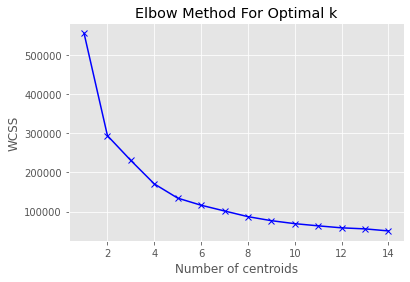

In [13]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
wcss = []
K = range(1,15)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(projected)
    wcss.append(km.inertia_)
plt.plot(K, wcss, 'bx-')
plt.xlabel('Number of centroids')
plt.ylabel('WCSS')
plt.title('Elbow Method For Optimal k')
plt.show()

In [14]:
%%time
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier

cv = StratifiedKFold(n_splits=10)
#trained one time then dumped out to google drive for re-use withouth having to re-train
#clf = RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
#                       criterion='gini', max_depth=20, max_features='auto',
#                       max_leaf_nodes=None, max_samples=None,
#                       min_impurity_decrease=0.0, min_impurity_split=None,
#                       min_samples_leaf=1, min_samples_split=2,
#                       min_weight_fraction_leaf=0.0, n_estimators=500,
#                       n_jobs=None, oob_score=False, random_state=101,
#                       verbose=0, warm_start=False)

CPU times: user 24 µs, sys: 11 µs, total: 35 µs
Wall time: 38.9 µs


In [15]:
from google.colab import drive
drive.mount('/content/drive/')
#My Drive/ColabNotebooks/')
url_rfmodel = '/content/drive/My Drive/ColabNotebooks/rfmodelbasecluster.joblib'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


In [0]:
#exporting model to drive
from joblib import dump, load
#dump(clf, url_rfmodel) 

In [17]:
%%time
#importing model to new model name
clf = load(url_rfmodel)

CPU times: user 641 µs, sys: 1.29 ms, total: 1.94 ms
Wall time: 265 ms


In [0]:
#X1_train_res, y1_train_res
acc = cross_val_score(clf,X1_train_res,y=y1_train_res,cv=cv)

print ("Average accuracy = ", acc.mean()*100, "+-", acc.std()*100)

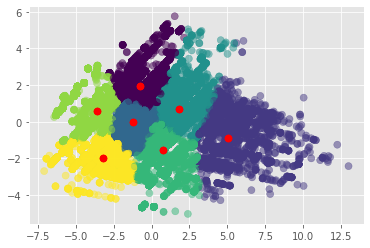

In [18]:
#converting our projected array to pandas df
pca=pd.DataFrame(projected)
pca.columns=['First Component','Second Component']
#build our algorithm with k=7, train it on pca and make predictions
kmeans = KMeans(n_clusters=7, init='k-means++', random_state=0).fit(pca)
y_kmeans = kmeans.predict(pca)
newfeature = kmeans.labels_
X1CV = np.column_stack((X1_train_res,pd.get_dummies(newfeature)))
#plotting the results 
plt.scatter(pca['First component'], pca['Second Component'], c=y_kmeans, s=50, alpha=0.5,cmap='viridis')
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='red', s=50)
plt.scatter(centers[:, 0], centers[:, 1], c='red', s=50)

In [61]:
y_kmeans

array([0, 3, 6, ..., 2, 3, 6], dtype=int32)

In [0]:
acc = cross_val_score(clf,X1CV,y=y1_train_res,cv=cv)

print ("Average accuracy (with kmeans for liquor type)= ", acc.mean()*100, "+-", acc.std()*100)

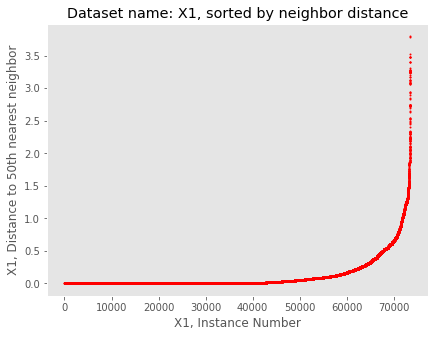

In [19]:
# lets first look at the connectivity of the graphs and distance to the nearest neighbors
from sklearn.neighbors import kneighbors_graph

#=======================================================
# CHANGE THESE VALUES TO ADJUST MINPTS FOR EACH DATASET
X1_N = 50
#=======================================================

# create connectivity graphs before calcualting the hierarchy
X1_knn_graph = kneighbors_graph(X1_train_res, X1_N, mode='distance') # calculate distance to four nearest neighbors


N1 = X1_knn_graph.shape[0]
X1_4nn_distances = np.zeros((N1,1))
for i in range(N1):
    X1_4nn_distances[i] = X1_knn_graph[i,:].max()

X1_4nn_distances = np.sort(X1_4nn_distances, axis=0)


plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(range(N1), X1_4nn_distances, 'r.', markersize=2) #plot the data
plt.title('Dataset name: X1, sorted by neighbor distance')
plt.xlabel('X1, Instance Number')
plt.ylabel('X1, Distance to {0}th nearest neighbor'.format(X1_N))
plt.grid()

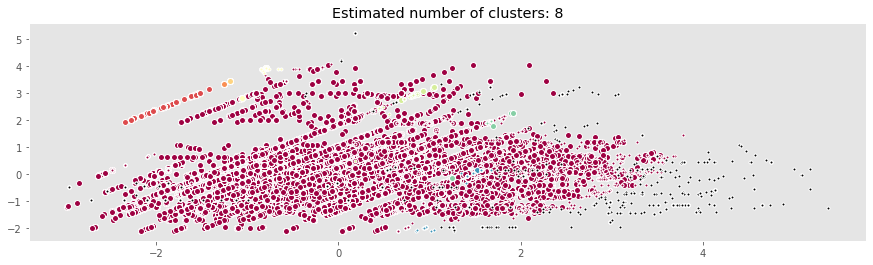

CPU times: user 3.39 s, sys: 1.39 s, total: 4.78 s
Wall time: 4.79 s


In [20]:
%%time 

from sklearn.cluster import DBSCAN

#=====================================
# ENTER YOUR CODE HERE TO CHANGE MINPTS AND EPS FOR EACH DATASET
X1_minpts = X1_N # from above
X1_eps = .45
#=====================================



db = DBSCAN(eps=X1_eps, min_samples=X1_minpts).fit(pca)
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)

# mark the samples that are considered "core"
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True

plt.figure(figsize=(15,4))
unique_labels = set(labels) # the unique labels
colors = plt.cm.Spectral(np.linspace(0, 1, len(unique_labels)))
for k, col in zip(unique_labels, colors):
        if k == -1:
            # Black used for noise.
            col = 'k'

        class_member_mask = (labels == k)

        xy = X1_train_res[class_member_mask & core_samples_mask]
        # plot the core points in this class
        plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=col,
                 markeredgecolor='w', markersize=6)

        # plot the remaining points that are edge points
        xy = X1_train_res[class_member_mask & ~core_samples_mask]
        plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=col,
                 markeredgecolor='w', markersize=3)

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.grid()
plt.show()

In [0]:
pca=pd.DataFrame(projected)
pca.columns=['First Component','Second Component']
#pcasubset=pca.sample(n=30000)

In [0]:
pcaydf = pca.merge(ydf, left_index=True, right_index=True)

In [0]:
pcaydf = pcaydf.rename(columns={0: 'Liquorlabel'})

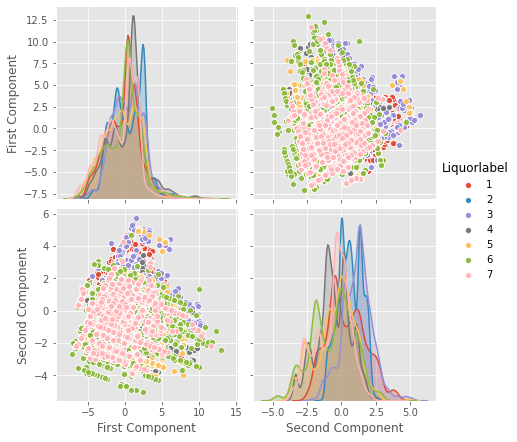

In [71]:
import seaborn as sns
sns.pairplot(pcaydf, height=3, hue= 'Liquorlabel', vars = ['First Component', 'Second Component'])

In [0]:

%%time
# an example using precomputed affinity, which uses the actual proximity graph
from sklearn.cluster import SpectralClustering
from sklearn.neighbors import NearestNeighbors

# See below for all avaiable parameters: 
#   https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.NearestNeighbors.html
neigh = NearestNeighbors(10, algorithm='ball_tree', n_jobs=-1)
neigh.fit(pca)
Xknn = neigh.kneighbors_graph()

spc = SpectralClustering(n_clusters=7, affinity = 'precomputed')
labels = spc.fit_predict(Xknn) 



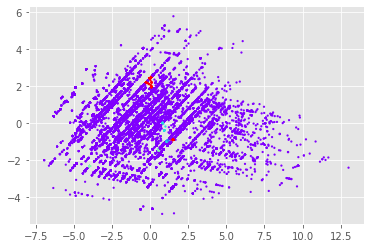

In [53]:
plt.scatter(pca['First Component'], pca['Second Component'], c=labels,
                    cmap=plt.cm.rainbow, s=5, linewidths=0)

plt.show()

In [0]:
%%time
# an example using SpectralClustering, which assumes that the graphical data needs to be calculated from the structure
from sklearn.cluster import SpectralClustering

X = pcasubset
nclust = 7

# If a string, this may be one of 
#  ‘nearest_neighbors’, ‘precomputed’, ‘rbf’ 
#  or one of the kernels supported by sklearn.metrics.pairwise_kernels
spc = SpectralClustering(n_clusters=nclust, affinity = 'nearest_neighbors')
labels = spc.fit_predict(X)

plt.scatter(X.iloc[:, 0].values, X.iloc[:, 1].values, c=labels,
                    cmap=plt.cm.rainbow, s=5, linewidths=0)

plt.show()

In [0]:
#My Drive/ColabNotebooks/')
url_rfmodel = '/content/drive/My Drive/ColabNotebooks/spc1.joblib'
#exporting model to drive
from joblib import dump, load
dump(spc, url_rfmodel) 

## Modeling and Evaluation 2 (10 points)

Evaluate and Compare (10 Points)
• Eval: Use internal and/or external validation measures to describe and compare the
clusterings and the clusters— how did you determine a suitable number of clusters for each
method?  


## Modeling and Evaluation 3 (10 points)

Visualize Results
• Visualize: Use tables/visualization to discuss the found results. Explain each visualization in
detail.  


## Modeling and Evaluation 4 (20 points)

Summarize the Ramifications
• Summarize: Describe your results. What findings are the most interesting and why

Option B: Association Rule Mining    
• Train: Create frequent itemsets and association rules (adjust parameters).  
• Eval: Use several measures for evaluating how interesting different rules are.  
• Visualize: Use tables/visualization to discuss the found results.  
• Summarize: Describe your results. What findings are the most compelling and why?    
Option C: Collaborative Filtering     
• Train: Create user-item matrices or item-item matrices using collaborative filtering (adjust
parameters).  
• Eval: Determine performance of the recommendations using different performance
measures (explain the ramifications of each measure). 
MSDS 7331 Course Overview & Schedule 29  
• Visualize: Use tables/visualization to discuss the found results. Explain each visualization in
detail.      

## Deployment (10 points)



Be critical of your performance and tell the reader how you current model might be usable by
other parties.  
• Did you achieve your goals? If not, can you reign in the utility of your modeling?  
• How useful is your model for interested parties (i.e., the companies or organizations that
might want to use it)?  
• How would you deploy your model for interested parties?  
• What other data should be collected?  
• How often would the model need to be updated, etc.?  

https://hdbscan.readthedocs.io/en/latest/performance_and_scalability.html
Interactive	Get Coffee	Over Lunch	Overnight
AffinityPropagation	2000	10000	25000	100000
Spectral	2000	5000	25000	75000
Agglomerative	2000	10000	25000	100000
DeBaCl	5000	25000	75000	250000
ScipySingleLinkage	25000	50000	100000	250000
Fastcluster	50000	100000	500000	1000000
HDBSCAN	100000	500000	1000000	5000000
DBSCAN	75000	250000	1000000	2500000
SKLearn KMeans	1000000000	1000000000	1000000000	1000000000

## Exceptional Work (10 points)


You have free reign to provide additional analyses or combine analyses